In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Dance.zip' -d /tmp/

Archive:  /content/drive/My Drive/Dance.zip
   creating: /tmp/dataset/
   creating: /tmp/dataset/test/
  inflating: /tmp/dataset/test/508.jpg  
  inflating: /tmp/dataset/test/246.jpg  
  inflating: /tmp/dataset/test/473.jpg  
  inflating: /tmp/dataset/test/485.jpg  
  inflating: /tmp/dataset/test/128.jpg  
  inflating: /tmp/dataset/test/410.jpg  
  inflating: /tmp/dataset/test/465.jpg  
  inflating: /tmp/dataset/test/196.jpg  
  inflating: /tmp/dataset/test/340.jpg  
  inflating: /tmp/dataset/test/467.jpg  
  inflating: /tmp/dataset/test/306.jpg  
  inflating: /tmp/dataset/test/171.jpg  
  inflating: /tmp/dataset/test/323.jpg  
  inflating: /tmp/dataset/test/332.jpg  
  inflating: /tmp/dataset/test/330.jpg  
  inflating: /tmp/dataset/test/170.jpg  
  inflating: /tmp/dataset/test/479.jpg  
  inflating: /tmp/dataset/test/9.jpg  
  inflating: /tmp/dataset/test/283.jpg  
  inflating: /tmp/dataset/test/114.jpg  
  inflating: /tmp/dataset/test/507.jpg  
  inflating: /tmp/dataset/test/183.jpg

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from skimage import io, transform
from __future__ import print_function, division
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dftrain = pd.read_csv('/tmp/dataset/train.csv')
dftest = pd.read_csv('/tmp/dataset/test.csv')

In [ ]:
dftrain.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


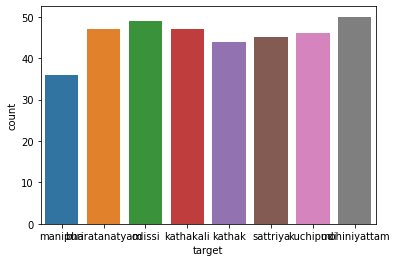

In [ ]:
import seaborn as sns
sns.countplot("target",data = dftrain)

In [ ]:
target_map={'manipuri':0, 'bharatanatyam':1, 'odissi':2, 'kathakali':3, 'kathak':4,'sattriya':5, 'kuchipudi':6, 'mohiniyattam':7}
dftrain['target']=dftrain['target'].map(target_map)

In [ ]:
dftrain.head()

,Image,target
0,96.jpg,0
1,163.jpg,1
2,450.jpg,2
3,219.jpg,3
4,455.jpg,2


In [ ]:
from sklearn.utils import shuffle
dftrain = shuffle(dftrain)
training=dftrain[:292]
validation=dftrain[292:]

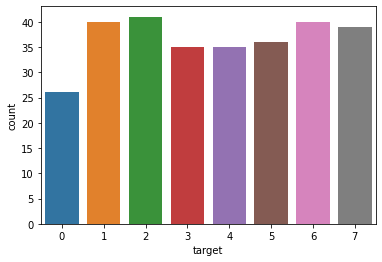

In [ ]:
sns.countplot("target",data = training)

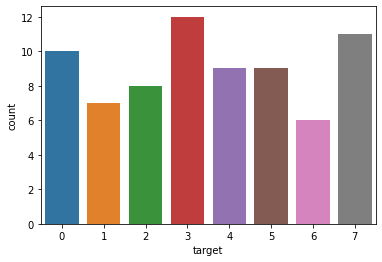

In [ ]:
sns.countplot("target",data = validation)

In [ ]:
# Start by creating a list
img_sizes = []
rejected = []

for item in training.Image:
    try:
        with Image.open('/tmp/dataset/train/'+item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  292
Rejects: 0


In [ ]:
df_img = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df_img[0].describe(),df_img[1].describe()

(count     292.000000
 mean      456.938356
 std       450.672033
 min       139.000000
 25%       220.000000
 50%       275.000000
 75%       522.250000
 max      4477.000000
 Name: 0, dtype: float64, count     292.000000
 mean      434.681507
 std       461.666380
 min       126.000000
 25%       197.750000
 50%       274.000000
 75%       485.000000
 max      3872.000000
 Name: 1, dtype: float64)

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomRotation(15),      
        transforms.RandomHorizontalFlip(), 
        transforms.Resize(416),             
        transforms.CenterCrop(416),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(416),
        transforms.CenterCrop(416),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, imgz,labels=None, root_dir='', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = imgz
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.images[idx])
        image = Image.open(img_name).convert('RGB')
#         plt.imshow(image)
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            return image, self.labels[idx]
        else:
            return image

In [ ]:
train_data = CustomDataset(imgz=training['Image'].values,labels=training['target'].values,root_dir='/tmp/dataset/train/',transform=train_transform)
validation_data = CustomDataset(imgz=validation['Image'].values,labels=validation['target'].values,root_dir='/tmp/dataset/train/', transform=test_transform)
total_test_data = CustomDataset(imgz=dftest['Image'].values,root_dir='/tmp/dataset/test/', transform=test_transform)

In [ ]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_data,shuffle=True)

In [ ]:
class_names = dftrain.target.unique()

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(validation_data)}')

[4 5 7 2 1 3 0 6]
Training images available: 292
Testing images available:  72


In [ ]:
total_train_data = CustomDataset(imgz=dftrain['Image'].values,labels=dftrain['target'].values,root_dir='/tmp/dataset/train/',transform=train_transform)
total_train_loader = DataLoader(total_train_data, batch_size=16, shuffle=True)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [ ]:
from torchvision import datasets, transforms, models

In [ ]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def prediciton(net, data_loader):
    test_pred = torch.LongTensor()
    for i, data in enumerate(data_loader):
        if torch.cuda.is_available():
          pass

        output = net(data)
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
    
    return test_pred


Model 1 resnet18 

92% accuracy

In [ ]:
from torch import optim
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc =  nn.Sequential(nn.Linear(num_ftrs, 256),
                                 nn.Dropout(0.5),
                                 nn.Linear(256, 8),
                                 nn.LogSoftmax(dim=1))



criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)




Model 2 resnet18

87% accuracy


In [ ]:
from torch import optim
model_ft = models.squeezenet1_0(pretrained=True)

                                 
model_ft.classifier[1] = nn.Conv2d(512, 8, kernel_size=(1,1), stride=(1,1))


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth


In [ ]:
dataloaders = {'train':train_loader,"val":validation_loader}

In [ ]:
dataset_sizes = {'train':len(train_data),'val':len(validation_data)}

In [ ]:
import time
import copy
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50)

Epoch 0/49
----------


In [ ]:
test_pred = prediciton(model_ft, total_test_loader)

In [ ]:
test_pred.numpy().shape

(156, 1)

In [ ]:
target_map_inv={v:k for k,v in target_map.items()}
dftest['target']=test_pred.numpy()
dftest.target=dftest.target.map(target_map_inv)

In [ ]:
dftest.to_csv('submission.csv',index=False)

In [ ]:
dftest.to_csv('/content/drive/My Drive/DL/submission.csv',index=False)